In [2]:
import pandas as pd

df = pd.read_csv('data_homophily.csv')
print(df.head())

   vacc_self  vacc_others01  vacc_others02  vacc_others03  vacc_others04  \
0        5.0              0              0              0              0   
1        5.0              0              0              9              0   
2        5.0              0              0             48              0   
3        5.0             25             15             10              0   
4        5.0              0              0              0            100   

   vacc_others05  masks_self  masks_others_never  masks_others_sometimes  \
0            100         5.0                   0                       0   
1             91         5.0                   0                       0   
2             52         5.0                   4                       0   
3             50         5.0                   6                      15   
4              0         5.0                   0                       0   

   masks_others_half  masks_others_often  masks_others_always  testing_self  \
0      

In [3]:
import numpy as np
from typing import Dict, Tuple, Optional, Literal
import pandas as pd
import matplotlib.pyplot as plt

def get_behavior_group_counts(
    df: pd.DataFrame,
    behavior_type: Literal["vacc", "masks", "testing"]
) -> np.ndarray:
    """
    Get the count of individuals in each behavior group.
    
    Args:
        df: DataFrame containing survey data
        behavior_type: Type of behavior ("vacc", "masks", or "testing")
        
    Returns:
        Array of counts for each behavior group (5 bins)
    """
    # Clean data and prepare
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    n_bins = 5
    
    # Get self-reported behavior
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Count individuals per self-reported group
    group_counts = np.zeros(n_bins)
    for i in range(n_bins):
        group_counts[i] = np.sum(self_behavior == i+1)
    
    return group_counts

def calculate_polarization_with_error(
    behavior_values: np.ndarray, 
    behavior_positions: Optional[np.ndarray] = None,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95
) -> Dict:
    """
    Calculate polarization (4 * variance) and its error from behavior values.
    
    Parameters:
    -----------
    behavior_values : array-like
        Values representing counts or raw frequencies at each behavior level.
        Will be normalized within the function.
    behavior_positions : array-like, optional
        Positions corresponding to each behavior value.
        If None, positions will be evenly spaced from 0 to 1.
    n_bootstrap : int, default=1000
        Number of bootstrap samples to use for error estimation.
    confidence_level : float, default=0.95
        Confidence level for the error bounds.
    
    Returns:
    --------
    dict
        A dictionary containing:
        - mean: the mean of the distribution
        - variance: the variance of the distribution
        - polarization: 4 * variance
        - polarization_std_error: standard error of polarization
        - polarization_ci: confidence interval for polarization
    """
    # Convert input to numpy array
    values = np.array(behavior_values, dtype=float)
    
    # Normalize values to probabilities
    total = np.sum(values)
    if total <= 0:
        raise ValueError("behavior_values must sum to a positive value")
    prob_values = values / total
    
    # If positions not provided, create evenly spaced positions from 0 to 1
    if behavior_positions is None:
        positions = np.linspace(0, 1, len(values))
    else:
        positions = np.array(behavior_positions)
    
    # Ensure the arrays are the same length
    if len(positions) != len(values):
        raise ValueError("behavior_values and behavior_positions must have the same length")
    
    # Function to calculate polarization from probability values
    def calc_pol(probs):
        mean = np.sum(positions * probs)
        variance = np.sum(probs * (positions - mean)**2)
        return 4 * variance
    
    # Calculate polarization for the original data
    polarization = calc_pol(prob_values)
    
    # Bootstrap to estimate error
    bootstrap_polarizations = []
    for _ in range(n_bootstrap):
        # Generate bootstrap sample (multinomial draw)
        bootstrap_sample = np.random.multinomial(total, prob_values, size=1)[0]
        bootstrap_probs = bootstrap_sample / np.sum(bootstrap_sample)
        bootstrap_polarizations.append(calc_pol(bootstrap_probs))
    
    # Calculate statistics from bootstrap samples
    bootstrap_polarizations = np.array(bootstrap_polarizations)
    polarization_std_error = np.std(bootstrap_polarizations, ddof=1)
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100
    polarization_ci = np.percentile(bootstrap_polarizations, [lower_percentile, upper_percentile])
    
    # Calculate mean and variance for original data
    mean = np.sum(positions * prob_values)
    variance = np.sum(prob_values * (positions - mean)**2)
    
    return {
        'mean': mean,
        'variance': variance,
        'polarization': polarization,
        'polarization_std_error': polarization_std_error,
        'polarization_ci': polarization_ci
    }

In [4]:
df = pd.read_csv('data_homophily.csv')

mask_counts = get_behavior_group_counts(df, "masks")
results = calculate_polarization_with_error(mask_counts)
print(f"Polarization: {results['polarization']:.4f} ± {results['polarization_std_error']:.4f}")
print(f"95% CI: [{results['polarization_ci'][0]:.4f}, {results['polarization_ci'][1]:.4f}]")

testing_counts = get_behavior_group_counts(df, "testing")
results = calculate_polarization_with_error(testing_counts)
print(f"Polarization: {results['polarization']:.4f} ± {results['polarization_std_error']:.4f}")
print(f"95% CI: [{results['polarization_ci'][0]:.4f}, {results['polarization_ci'][1]:.4f}]")

df = pd.read_csv('data_homophily.csv')
vacc_counts = get_behavior_group_counts(df, "vacc")
results = calculate_polarization_with_error(vacc_counts)
print(f"Polarization: {results['polarization']:.4f} ± {results['polarization_std_error']:.4f}")
print(f"95% CI: [{results['polarization_ci'][0]:.4f}, {results['polarization_ci'][1]:.4f}]")


Polarization: 0.2898 ± 0.0124
95% CI: [0.2668, 0.3152]
Polarization: 0.4780 ± 0.0109
95% CI: [0.4566, 0.4994]
Polarization: 0.5637 ± 0.0135
95% CI: [0.5361, 0.5888]


In [12]:
1+1

2

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Literal
from scipy.interpolate import interp1d
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Homophily Parameter Estimates with Standard Deviations:
--------------------------------------------------------------------------------
Behavior     Optimal h    Std Dev (σ)  h ± σ                Effective N 
--------------------------------------------------------------------------------
Masks        2.4525       1.6627       [0.7898, 4.1151]     208.3       
Testing      2.3323       1.8541       [0.4783, 4.1864]     237.7       
Vaccination  1.7518       1.8979       [-0.1462, 3.6497]    224.8       
Figure saved to homophily_analysis_with_std.png


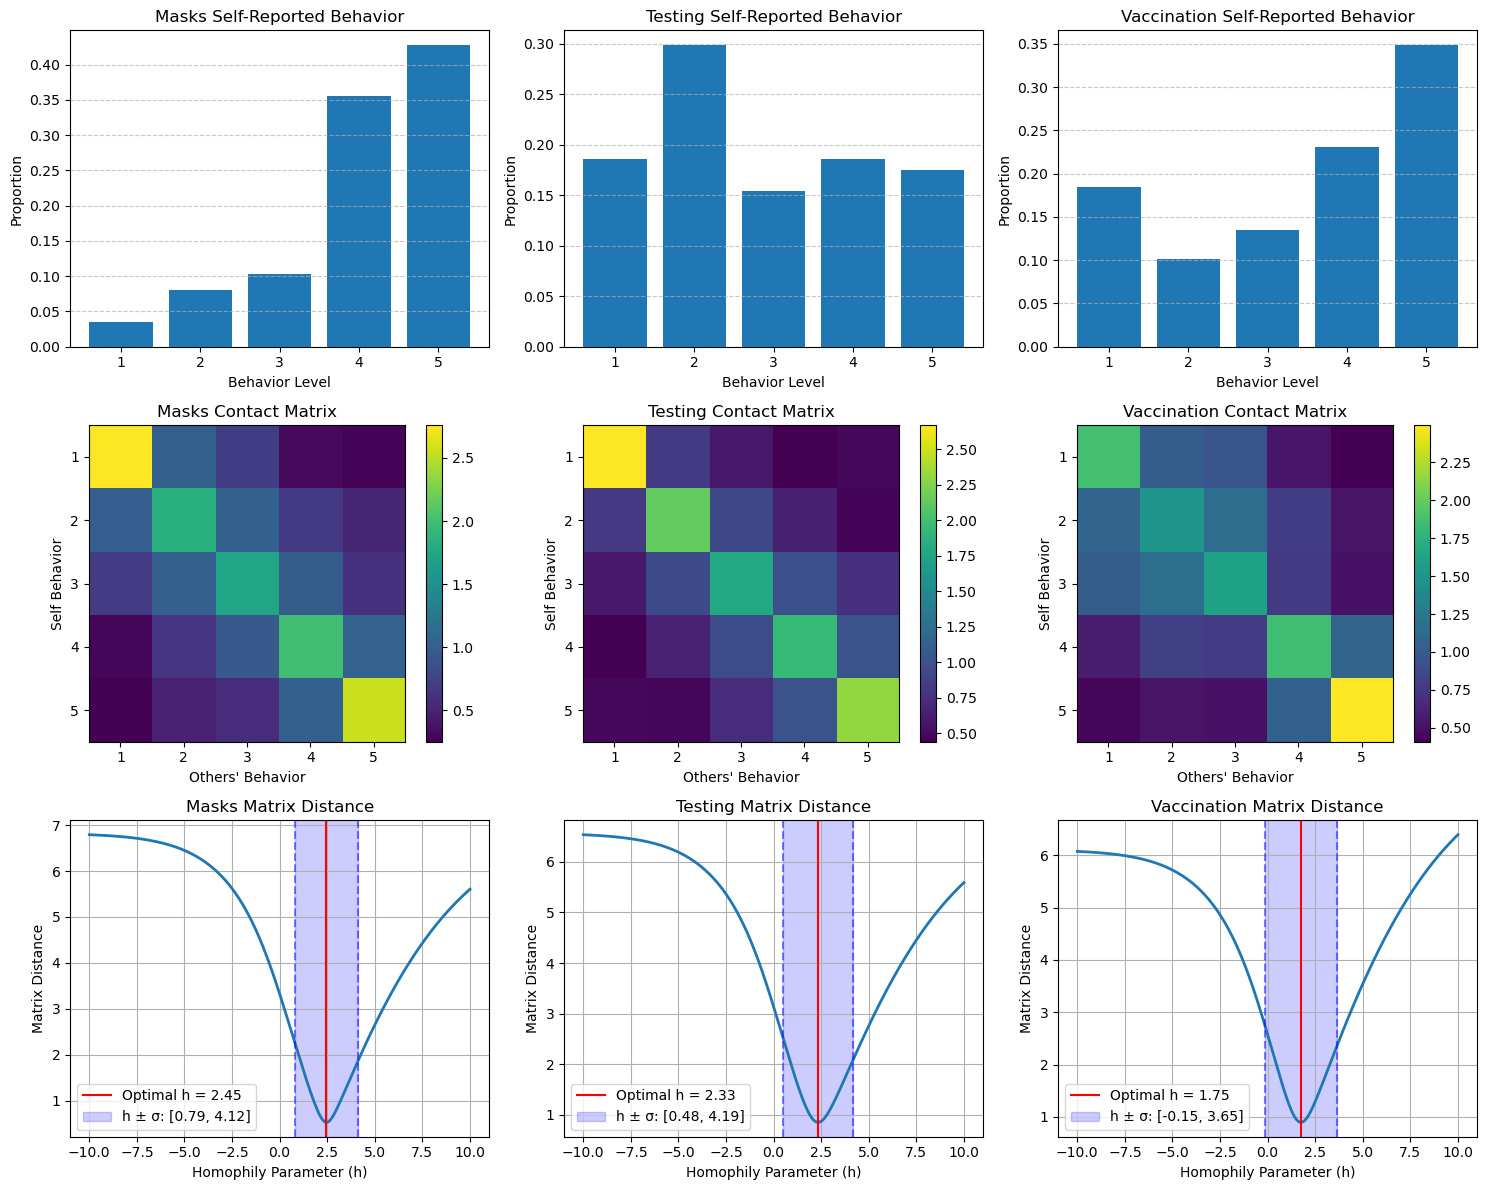

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Literal
from scipy.interpolate import interp1d
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling

def generate_matrices_and_vectors(
    df: pd.DataFrame,
    apply_sinkhorn: bool = True,
    symmetrize: bool = True,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Tuple[Dict[str, jnp.ndarray], Dict[str, jnp.ndarray]]:
    """
    Generate Sinkhorn-normalized contact matrices and behavior vectors for mask, test, and vaccine.
    
    Args:
        df: DataFrame containing survey data
        apply_sinkhorn: Whether to apply Sinkhorn normalization
        symmetrize: Whether to symmetrize the matrix before normalization
        max_iters: Maximum iterations for Sinkhorn normalization
        threshold: Convergence threshold for Sinkhorn normalization
        
    Returns:
        Tuple of:
        - Dictionary of Sinkhorn-normalized contact matrices for each behavior type
        - Dictionary of behavior vectors for each behavior type
    """
    # Define behavior types in the desired order: mask, test, vaccine
    behavior_types = ["masks", "testing", "vacc"]
    matrices = {}
    behavior_vectors = {}
    n_bins = 5
    
    for behavior_type in behavior_types:
        # Clean data and prepare
        df_clean = df.dropna(subset=[f'{behavior_type}_self'])
        
        # Get self-reported behavior and calculate behavior vector
        self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
        behavior_vector = np.zeros(n_bins)
        for i in range(n_bins):
            behavior_vector[i] = np.sum(self_behavior == i+1)
        behavior_vector = behavior_vector / np.sum(behavior_vector)  # Normalize
        behavior_vectors[behavior_type] = jnp.array(behavior_vector)
        
        # Initialize contact matrix
        contact_matrix = np.zeros((n_bins, n_bins))
        
        # Fill contact matrix based on behavior type
        if behavior_type == "vacc":
            cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
        else:
            cols = [
                f'{behavior_type}_others_never', 
                f'{behavior_type}_others_sometimes',
                f'{behavior_type}_others_half',
                f'{behavior_type}_others_often',
                f'{behavior_type}_others_always'
            ]
        
        # Aggregate responses into contact matrix
        for i, row in df_clean.iterrows():
            self_idx = int(row[f'{behavior_type}_self']) - 1
            for j, col in enumerate(cols):
                if pd.notna(row[col]):
                    contact_matrix[self_idx, j] += row[col]
        
        # Normalize by group counts to get average connections per individual
        raw_normalized = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                raw_normalized[i, :] = contact_matrix[i, :] / group_count
        
        # Symmetrize if requested
        if symmetrize:
            raw_normalized = 0.5 * (raw_normalized + raw_normalized.T)
        
        # Convert to JAX array
        raw_normalized_jax = jnp.array(raw_normalized)
        
        # Apply Sinkhorn normalization if requested
        if apply_sinkhorn:
            sinkhorn_normalized, _, _ = matrix_scaling(
                raw_normalized_jax, 
                max_iters=max_iters, 
                threshold=threshold
            )
            # Apply scaling after normalization
            matrices[behavior_type] = sinkhorn_normalized * (n_bins**2)
        else:
            matrices[behavior_type] = raw_normalized_jax * (n_bins**2)
    
    return matrices, behavior_vectors

def calculate_optimal_homophily(
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    h_range: Tuple[float, float] = (-10, 10),
    n_samples: int = 1000
) -> Tuple[Dict[str, float], Dict[str, Dict[float, float]]]:
    """
    Calculate the optimal homophily parameter and matrix distances for each behavior type.
    
    Args:
        matrices: Dictionary of empirical contact matrices
        behavior_vectors: Dictionary of behavior vectors
        h_range: Range limits for homophily values
        n_samples: Number of homophily values to sample
        
    Returns:
        Tuple of:
        - Dictionary of optimal homophily values for each behavior type
        - Dictionary of dictionaries containing distance metrics for each tested homophily value
    """
    # Define behavior types in the desired order: mask, test, vaccine
    behavior_types = ["masks", "testing", "vacc"]
    h_values = jnp.linspace(h_range[0], h_range[1], n_samples)
    optimal_h = {}
    all_distances = {}
    
    # Function to calculate distance between matrices
    def matrix_distance(m1, m2):
        # Frobenius norm (L2 distance)
        return jnp.sqrt(jnp.sum((m1 - m2) ** 2))
    
    for behavior_type in behavior_types:
        empirical_matrix = matrices[behavior_type]
        populations = behavior_vectors[behavior_type]
        n_groups = len(populations)
        
        # Calculate distance for each homophily value
        distances = {}
        
        for h in h_values:
            synthetic_matrix = create_contact_matrix(n_groups, h, populations)
            dist = matrix_distance(synthetic_matrix, empirical_matrix)
            distances[float(h)] = float(dist)
        
        # Find optimal homophily
        optimal_h[behavior_type] = min(distances, key=distances.get)
        all_distances[behavior_type] = distances
    
    return optimal_h, all_distances

def calculate_h_std_dev(
    distances: Dict[float, float],
    temperature: float = 1.0
) -> Tuple[float, float, float]:
    """
    Calculate the optimal homophily value and its standard deviation.
    
    Args:
        distances: Dictionary mapping h values to their L2 distances
        temperature: Temperature parameter for softening the distribution
        
    Returns:
        Tuple of:
        - Optimal h value (minimum distance)
        - Standard deviation of h
        - Effective sample size
    """
    # Convert distances to arrays
    h_values = np.array(sorted(distances.keys()))
    dist_values = np.array([distances[h] for h in h_values])
    
    # Find the optimal h (minimum distance)
    min_idx = np.argmin(dist_values)
    optimal_h = h_values[min_idx]
    
    # Convert distances to weights (higher weight = lower distance)
    # Use softmax-like transformation with temperature parameter
    weights = np.exp(-dist_values / temperature)
    
    # Normalize weights to sum to 1 (probability distribution)
    weights = weights / np.sum(weights)
    
    # Calculate weighted mean (should be close to optimal_h)
    weighted_mean = np.sum(h_values * weights)
    
    # Calculate weighted variance
    variance = np.sum(weights * (h_values - weighted_mean)**2)
    
    # Standard deviation
    std_dev = np.sqrt(variance)
    
    # Calculate effective sample size (lower when distribution is more spread out)
    effective_n = 1.0 / np.sum(weights**2)
    
    return optimal_h, std_dev, effective_n

def generate_comparison_figure_with_std(
    df: pd.DataFrame,
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    distances: Dict[str, Dict[float, float]],
    optimal_h: Dict[str, float],
    figsize: Tuple[int, int] = (15, 12)
) -> plt.Figure:
    """
    Generate a 3x3 comparison figure for mask, test, and vaccine data,
    including optimal h and standard deviation.
    
    Args:
        df: DataFrame containing survey data
        matrices: Dictionary of contact matrices
        behavior_vectors: Dictionary of behavior vectors
        distances: Dictionary of dictionaries with distance metrics
        optimal_h: Dictionary of optimal homophily values
        figsize: Figure size
        
    Returns:
        Matplotlib Figure object
    """
    #Mh = np.array([2.2041, 2.4490, 2.7551])
    #Th = np.array([2.1429, 2.3265, 2.5102])
    #Vh = np.array([1.6515, 1.7755, 1.8980])


    # Define behavior types in the desired order: mask, test, vaccine
    behavior_types = ["masks", "testing", "vacc"]
    behavior_labels = ["Masks", "Testing", "Vaccination"]
    
    # Calculate standard deviation for each behavior type
    std_devs = {}
    for behavior_type in behavior_types:
        optimal_h_val, std_dev, effective_n = calculate_h_std_dev(distances[behavior_type])
        std_devs[behavior_type] = {
            'optimal': optimal_h_val,
            'std_dev': std_dev,
            'effective_n': effective_n
        }
    
    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    # Plot data for each behavior type
    for col, (behavior_type, label) in enumerate(zip(behavior_types, behavior_labels)):
        # Top row: Histogram of self-reported behavior
        ax_hist = axes[0, col]
        behavior_vector = behavior_vectors[behavior_type]
        ax_hist.bar(range(1, len(behavior_vector)+1), behavior_vector)
        ax_hist.set_title(f"{label} Self-Reported Behavior")
        ax_hist.set_xlabel("Behavior Level")
        ax_hist.set_ylabel("Proportion")
        ax_hist.set_xticks(range(1, len(behavior_vector)+1))
        ax_hist.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Middle row: Normalized contact matrix
        ax_matrix = axes[1, col]
        im = ax_matrix.imshow(matrices[behavior_type], cmap='viridis')
        ax_matrix.set_title(f"{label} Contact Matrix")
        ax_matrix.set_xlabel("Others' Behavior")
        ax_matrix.set_ylabel("Self Behavior")
        ax_matrix.set_xticks(range(len(behavior_vector)))
        ax_matrix.set_yticks(range(len(behavior_vector)))
        ax_matrix.set_xticklabels(range(1, len(behavior_vector)+1))
        ax_matrix.set_yticklabels(range(1, len(behavior_vector)+1))
        plt.colorbar(im, ax=ax_matrix)
        
        # Bottom row: L2 distance curve with standard deviation
        ax_dist = axes[2, col]
        h_vals = sorted(distances[behavior_type].keys())
        d_vals = [distances[behavior_type][h] for h in h_vals]
        ax_dist.plot(h_vals, d_vals, '-', linewidth=2)
        
        # Add optimal h and standard deviation
        std_data = std_devs[behavior_type]
        optimal_h_val = std_data['optimal']
        std_dev = std_data['std_dev']
        
        # Plot optimal h
        ax_dist.axvline(x=optimal_h_val, color='r', linestyle='-', 
                       label=f'Optimal h = {optimal_h_val:.2f}')
        
        # Add standard deviation range as shaded area
        ax_dist.axvspan(
            optimal_h_val - std_dev, 
            optimal_h_val + std_dev, 
            alpha=0.2, 
            color='blue',
            label=f'h ± σ: [{optimal_h_val-std_dev:.2f}, {optimal_h_val+std_dev:.2f}]'
        )
        
        # Add vertical lines for std dev bounds
        ax_dist.axvline(x=optimal_h_val - std_dev, color='blue', linestyle='--', alpha=0.5)
        ax_dist.axvline(x=optimal_h_val + std_dev, color='blue', linestyle='--', alpha=0.5)
        
        ax_dist.set_xlabel("Homophily Parameter (h)")
        ax_dist.set_ylabel("Matrix Distance")
        ax_dist.set_title(f"{label} Matrix Distance")
        ax_dist.legend()
        ax_dist.grid(True)
    
    plt.tight_layout()
    return fig

def analyze_behavior_homophily_with_std(
    csv_path: str = 'data_homophily.csv',
    n_samples: int = 1000,
    h_range: Tuple[float, float] = (-10, 10),
    save_figure: bool = False,
    figure_path: str = 'homophily_analysis_with_std.png'
) -> Dict:
    """
    Analyze homophily for all behavior types and generate comparison figure with standard deviation.
    
    Args:
        csv_path: Path to the CSV file with survey data
        n_samples: Number of homophily values to sample
        h_range: Range of homophily values to test
        save_figure: Whether to save the figure to file
        figure_path: Path to save the figure
        
    Returns:
        Dictionary of results including optimal homophily values, standard deviations, and figure
    """
    # Load data
    df = pd.read_csv(csv_path)
    
    # Generate matrices and behavior vectors
    matrices, behavior_vectors = generate_matrices_and_vectors(df)
    
    # Calculate optimal homophily and distances
    optimal_h, distances = calculate_optimal_homophily(
        matrices, 
        behavior_vectors, 
        h_range=h_range,
        n_samples=n_samples
    )
    
    # Calculate standard deviations for each behavior type
    std_devs = {}
    for behavior_type in ["masks", "testing", "vacc"]:
        optimal_h_val, std_dev, effective_n = calculate_h_std_dev(distances[behavior_type])
        std_devs[behavior_type] = {
            'optimal': optimal_h_val,
            'std_dev': std_dev,
            'effective_n': effective_n
        }
    
    # Generate comparison figure with standard deviation
    fig = generate_comparison_figure_with_std(
        df, 
        matrices, 
        behavior_vectors, 
        distances, 
        optimal_h
    )
    
    # Print optimal homophily values and standard deviations
    print("Homophily Parameter Estimates with Standard Deviations:")
    print("-" * 80)
    print(f"{'Behavior':<12} {'Optimal h':<12} {'Std Dev (σ)':<12} {'h ± σ':<20} {'Effective N':<12}")
    print("-" * 80)
    
    for behavior_type, label in zip(["masks", "testing", "vacc"], ["Masks", "Testing", "Vaccination"]):
        std_data = std_devs[behavior_type]
        optimal_h_val = std_data['optimal']
        std_dev = std_data['std_dev']
        effective_n = std_data['effective_n']
        h_range_str = f"[{optimal_h_val-std_dev:.4f}, {optimal_h_val+std_dev:.4f}]"
        
        print(f"{label:<12} {optimal_h_val:<12.4f} {std_dev:<12.4f} {h_range_str:<20} {effective_n:<12.1f}")
    
    # Save figure if requested
    if save_figure:
        fig.savefig(figure_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {figure_path}")
    
    # Display figure
    plt.show()
    
    # Return results
    return {
        'matrices': matrices,
        'behavior_vectors': behavior_vectors,
        'optimal_h': optimal_h,
        'distances': distances,
        'std_devs': std_devs,
        'figure': fig
    }

# Example usage:
# results = analyze_behavior_homophily_with_std('data_homophily.csv')

results = analyze_behavior_homophily_with_std(
    csv_path='data_homophily.csv',
    n_samples=1000,
    h_range=(-10, 10),
    save_figure=True,
    figure_path='homophily_analysis_with_std.png'
)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List, Literal, Optional
from scipy.interpolate import interp1d
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling

def create_empirical_contact_matrix(
    df: pd.DataFrame,
    behavior_type: Literal["vacc", "masks", "testing"],
    apply_sinkhorn: bool = True,
    symmetrize: bool = True,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Create contact matrices from survey data.
    
    Args:
        df: DataFrame containing survey data
        behavior_type: Type of behavior ("vacc", "masks", or "testing")
        apply_sinkhorn: Whether to apply Sinkhorn normalization
        symmetrize: Whether to symmetrize the matrix before normalization
        max_iters: Maximum number of iterations for Sinkhorn normalization
        threshold: Convergence threshold for Sinkhorn normalization
        
    Returns:
        Tuple of:
        - Group counts (population sizes)
        - Raw normalized contact matrix
        - Sinkhorn-normalized contact matrix (if apply_sinkhorn=True, otherwise same as raw)
    """
    # Clean data and prepare
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    n_bins = 5
    
    # Initialize contact matrix
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # Get self-reported behavior
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Count individuals per self-reported group for normalization
    group_counts = np.zeros(n_bins)
    for i in range(n_bins):
        group_counts[i] = np.sum(self_behavior == i+1)
    
    # Fill contact matrix based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Aggregate responses into contact matrix
    for i, row in df_clean.iterrows():
        self_idx = int(row[f'{behavior_type}_self']) - 1
        for j, col in enumerate(cols):
            if pd.notna(row[col]):
                contact_matrix[self_idx, j] += row[col]
    
    # Normalize by group counts to get average connections per individual
    raw_normalized = np.zeros_like(contact_matrix)
    for i in range(n_bins):
        if group_counts[i] > 0:
            raw_normalized[i, :] = contact_matrix[i, :] / group_counts[i]
    
    # Symmetrize if requested
    if symmetrize:
        raw_normalized = 0.5 * (raw_normalized + raw_normalized.T)
    
    # Convert to JAX array
    raw_normalized_jax = jnp.array(raw_normalized)
    
    # Apply Sinkhorn normalization if requested
    if apply_sinkhorn:
        sinkhorn_normalized, _, _ = matrix_scaling(
            raw_normalized_jax, 
            max_iters=max_iters, 
            threshold=threshold
        )
        return jnp.array(group_counts), raw_normalized_jax, sinkhorn_normalized
    else:
        return jnp.array(group_counts), raw_normalized_jax, raw_normalized_jax

def calculate_optimal_homophily(
    empirical_matrix: jnp.ndarray,
    populations: jnp.ndarray,
    h_range: Tuple[float, float] = (-10, 10),
    n_samples: int = 1000
) -> Tuple[float, Dict[float, float]]:
    """
    Calculate the optimal homophily parameter and matrix distances.
    
    Args:
        empirical_matrix: Empirical contact matrix
        populations: Population sizes for each behavior group
        h_range: Range limits for homophily values
        n_samples: Number of homophily values to sample
        
    Returns:
        Tuple of:
        - Optimal homophily value
        - Dictionary mapping h values to distances
    """
    h_values = np.linspace(h_range[0], h_range[1], n_samples)
    n_groups = len(populations)
    distances = {}
    
    # Function to calculate distance between matrices
    def matrix_distance(m1, m2):
        # Frobenius norm (L2 distance)
        return jnp.sqrt(jnp.sum((m1 - m2) ** 2))
    
    for h in h_values:
        synthetic_matrix = create_contact_matrix(n_groups, h, populations)
        dist = float(matrix_distance(synthetic_matrix, empirical_matrix))
        distances[float(h)] = dist
    
    # Find optimal homophily
    optimal_h = min(distances, key=distances.get)
    
    return optimal_h, distances

def bootstrap_homophily_estimation(
    df: pd.DataFrame,
    behavior_type: Literal["vacc", "masks", "testing"],
    n_bootstrap: int = 1000,
    h_range: Tuple[float, float] = (-10, 10),
    n_h_samples: int = 200,
    confidence_level: float = 0.95,
    apply_sinkhorn: bool = True,
    symmetrize: bool = True
) -> Dict:
    """
    Estimate homophily parameter with bootstrap confidence intervals.
    
    Args:
        df: DataFrame containing survey data
        behavior_type: Type of behavior ("vacc", "masks", or "testing")
        n_bootstrap: Number of bootstrap samples
        h_range: Range of homophily values to test
        n_h_samples: Number of homophily values to sample within the range
        confidence_level: Confidence level for intervals
        apply_sinkhorn: Whether to apply Sinkhorn normalization
        symmetrize: Whether to symmetrize matrices
        
    Returns:
        Dictionary with results including optimal h, standard error, and confidence intervals
    """
    # Get original matrix and population counts
    group_counts, _, original_matrix = create_empirical_contact_matrix(
        df, 
        behavior_type, 
        apply_sinkhorn=apply_sinkhorn, 
        symmetrize=symmetrize
    )
    
    # Scale matrix by population size to match expected behavior
    n_bins = len(group_counts)
    original_matrix = original_matrix * (n_bins**2)
    
    # Calculate optimal homophily on original data
    original_optimal_h, original_distances = calculate_optimal_homophily(
        original_matrix,
        group_counts,
        h_range=h_range,
        n_samples=n_h_samples
    )
    
    # Prepare for bootstrap
    bootstrap_h_values = []
    
    # Get relevant columns based on behavior type
    if behavior_type == "vacc":
        behavior_cols = [f'{behavior_type}_self'] + [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        behavior_cols = [f'{behavior_type}_self', 
                        f'{behavior_type}_others_never', 
                        f'{behavior_type}_others_sometimes',
                        f'{behavior_type}_others_half',
                        f'{behavior_type}_others_often',
                        f'{behavior_type}_others_always']
    
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    
    # Perform bootstrap resampling
    for i in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(len(df_clean), size=len(df_clean), replace=True)
        bootstrap_sample = df_clean.iloc[bootstrap_indices].copy()
        
        # Create empirical matrix from bootstrap sample
        bs_group_counts, _, bs_matrix = create_empirical_contact_matrix(
            bootstrap_sample,
            behavior_type,
            apply_sinkhorn=apply_sinkhorn,
            symmetrize=symmetrize
        )
        
        # Scale matrix
        bs_matrix = bs_matrix * (n_bins**2)
        
        # Calculate optimal homophily for this bootstrap sample
        bs_optimal_h, _ = calculate_optimal_homophily(
            bs_matrix,
            bs_group_counts,
            h_range=h_range,
            n_samples=n_h_samples
        )
        
        bootstrap_h_values.append(bs_optimal_h)
    
    # Calculate bootstrap statistics
    bootstrap_h_values = np.array(bootstrap_h_values)
    h_mean = np.mean(bootstrap_h_values)
    h_std_error = np.std(bootstrap_h_values, ddof=1)
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100
    h_ci = np.percentile(bootstrap_h_values, [lower_percentile, upper_percentile])
    
    return {
        'behavior_type': behavior_type,
        'optimal_h': original_optimal_h,
        'bootstrap_mean_h': h_mean,
        'h_std_error': h_std_error,
        'h_ci': h_ci,
        'bootstrap_samples': bootstrap_h_values,
        'distances': original_distances
    }

def analyze_all_behaviors_bootstrap(
    df: pd.DataFrame,
    n_bootstrap: int = 1000,
    h_range: Tuple[float, float] = (-10, 10),
    n_h_samples: int = 200,
    confidence_level: float = 0.95,
    apply_sinkhorn: bool = True,
    symmetrize: bool = True
) -> Dict[str, Dict]:
    """
    Analyze all behavior types using bootstrap for error estimation.
    
    Args:
        df: DataFrame containing survey data
        n_bootstrap: Number of bootstrap samples
        h_range: Range of homophily values to test
        n_h_samples: Number of homophily values to sample within the range
        confidence_level: Confidence level for intervals
        apply_sinkhorn: Whether to apply Sinkhorn normalization
        symmetrize: Whether to symmetrize matrices
        
    Returns:
        Dictionary mapping behavior types to their analysis results
    """
    behavior_types = ["masks", "testing", "vacc"]
    results = {}
    
    for behavior_type in behavior_types:
        print(f"Analyzing {behavior_type}...")
        results[behavior_type] = bootstrap_homophily_estimation(
            df,
            behavior_type,
            n_bootstrap=n_bootstrap,
            h_range=h_range,
            n_h_samples=n_h_samples,
            confidence_level=confidence_level,
            apply_sinkhorn=apply_sinkhorn,
            symmetrize=symmetrize
        )
    
    # Print summary
    print("\nHomophily Parameter Estimates with Bootstrap Error Analysis:")
    print("-" * 80)
    print(f"{'Behavior':<12} {'Optimal h':<12} {'Std Error':<12} {f'{confidence_level*100}% CI':<20}")
    print("-" * 80)
    
    for behavior_type, label in zip(behavior_types, ["Masks", "Testing", "Vaccination"]):
        result = results[behavior_type]
        optimal_h = result['optimal_h']
        h_std_error = result['h_std_error']
        h_ci = result['h_ci']
        ci_str = f"[{h_ci[0]:.4f}, {h_ci[1]:.4f}]"
        
        print(f"{label:<12} {optimal_h:<12.4f} {h_std_error:<12.4f} {ci_str:<20}")
    
    return results

In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv('data_homophily.csv')

# Run the analysis for all behavior types
results = analyze_all_behaviors_bootstrap(
    df,
    n_bootstrap=1000,          # Number of bootstrap samples
    h_range=(0, 3),         # Range of homophily values to test
    n_h_samples=50,           # Number of h values to sample within range
    confidence_level=0.95,     # Confidence level for intervals (95%)
    apply_sinkhorn=True,       # Apply Sinkhorn normalization
    symmetrize=True           # Don't symmetrize matrices (or set to True if desired)
)

# You can access individual results for each behavior type
masks_results = results['masks']
testing_results = results['testing']
vacc_results = results['vacc']

In [ ]:
# homophily values for masks, testing, and vaccination SE and 95% CI
Mh = np.array([2.2041, 2.4490, 2.7551])
Th = np.array([2.1429, 2.3265, 2.5102])
Vh = np.array([1.6515, 1.7755, 1.8980])

# polarization values for masks, testing, and vaccination
Mp = np.array([0.2658, 0.2898, 0.3149])
Tp = np.array([0.4575, 0.4780, 0.4981])
Vp = np.array([0.5387, 0.5637, 0.5913])


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from typing import Tuple, Dict
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling

def generate_matrices_and_vectors(
    df: pd.DataFrame,
    apply_sinkhorn: bool = True,
    symmetrize: bool = False,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Tuple[Dict[str, jnp.ndarray], Dict[str, jnp.ndarray]]:
    behavior_types = ["masks", "testing", "vacc"]
    matrices = {}
    behavior_vectors = {}
    n_bins = 5
    
    for behavior_type in behavior_types:
        df_clean = df.dropna(subset=[f'{behavior_type}_self'])
        
        self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
        behavior_vector = np.zeros(n_bins)
        for i in range(n_bins):
            behavior_vector[i] = np.sum(self_behavior == i+1)
        behavior_vector = behavior_vector / np.sum(behavior_vector)
        behavior_vectors[behavior_type] = jnp.array(behavior_vector)
        
        contact_matrix = np.zeros((n_bins, n_bins))
        
        if behavior_type == "vacc":
            cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
        else:
            cols = [
                f'{behavior_type}_others_never', 
                f'{behavior_type}_others_sometimes',
                f'{behavior_type}_others_half',
                f'{behavior_type}_others_often',
                f'{behavior_type}_others_always'
            ]
        
        for i, row in df_clean.iterrows():
            self_idx = int(row[f'{behavior_type}_self']) - 1
            for j, col in enumerate(cols):
                if pd.notna(row[col]):
                    contact_matrix[self_idx, j] += row[col]
        
        raw_normalized = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                raw_normalized[i, :] = contact_matrix[i, :] / group_count
        
        if symmetrize:
            raw_normalized = 0.5 * (raw_normalized + raw_normalized.T)
        
        raw_normalized_jax = jnp.array(raw_normalized)
        
        if apply_sinkhorn:
            sinkhorn_normalized, _, _ = matrix_scaling(
                raw_normalized_jax, 
                max_iters=max_iters, 
                threshold=threshold
            )
            matrices[behavior_type] = sinkhorn_normalized * (n_bins**2)
        else:
            matrices[behavior_type] = raw_normalized_jax * (n_bins**2)
    
    return matrices, behavior_vectors

def calculate_optimal_homophily(
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    h_range: Tuple[float, float] = (-10, 10),
    n_samples: int = 1000
) -> Tuple[Dict[str, float], Dict[str, Dict[float, float]]]:
    behavior_types = ["masks", "testing", "vacc"]
    h_values = jnp.linspace(h_range[0], h_range[1], n_samples)
    optimal_h = {}
    all_distances = {}
    
    def matrix_distance(m1, m2):
        return jnp.sqrt(jnp.sum((m1 - m2) ** 2))
    
    for behavior_type in behavior_types:
        empirical_matrix = matrices[behavior_type]
        populations = behavior_vectors[behavior_type]
        n_groups = len(populations)
        
        distances = {}
        
        for h in h_values:
            synthetic_matrix = create_contact_matrix(n_groups, h, populations)
            dist = matrix_distance(synthetic_matrix, empirical_matrix)
            distances[float(h)] = float(dist)
        
        optimal_h[behavior_type] = min(distances, key=distances.get)
        all_distances[behavior_type] = distances
    
    return optimal_h, all_distances

def calculate_h_std_dev(
    distances: Dict[float, float],
    temperature: float = 1.0
) -> Tuple[float, float, float]:
    h_values = np.array(sorted(distances.keys()))
    dist_values = np.array([distances[h] for h in h_values])
    
    min_idx = np.argmin(dist_values)
    optimal_h = h_values[min_idx]
    
    weights = np.exp(-dist_values / temperature)
    weights = weights / np.sum(weights)
    
    weighted_mean = np.sum(h_values * weights)
    variance = np.sum(weights * (h_values - weighted_mean)**2)
    std_dev = np.sqrt(variance)
    effective_n = 1.0 / np.sum(weights**2)
    
    return optimal_h, std_dev, effective_n


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:

# Load the data
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)

# Generate matrices and behavior vectors
matrices, behavior_vectors = generate_matrices_and_vectors(df)

# Calculate optimal homophily and distances
h_range = (-5, 5)
n_samples = 1000
optimal_h, distances = calculate_optimal_homophily(
    matrices, 
    behavior_vectors, 
    h_range=h_range,
    n_samples=n_samples
)

# Calculate standard deviations
std_devs = {}
for behavior_type in ["masks", "testing", "vacc"]:
    optimal_h_val, std_dev, effective_n = calculate_h_std_dev(distances[behavior_type])
    std_devs[behavior_type] = {
        'optimal': optimal_h_val,
        'std_dev': std_dev,
        'effective_n': effective_n
    }

# Store all results in a dictionary
results = {
    'matrices': matrices,
    'behavior_vectors': behavior_vectors,
    'optimal_h': optimal_h,
    'distances': distances,
    'std_devs': std_devs
}

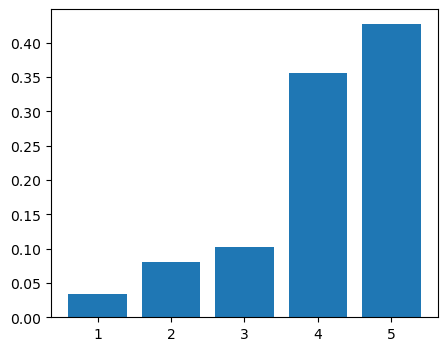

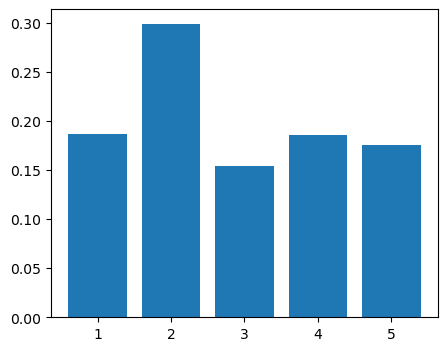

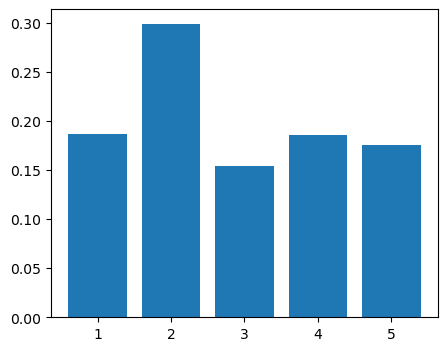

In [9]:
import matplotlib.pyplot as plt

behavior_type = "masks"
behavior_vector = results['behavior_vectors'][behavior_type]

plt.figure(figsize=(5, 4))
plt.bar(range(1, len(behavior_vector)+1), behavior_vector)
plt.xticks(range(1, len(behavior_vector)+1))
plt.savefig('figures/Fig_2/masks_self_reported_histogram.png', dpi=300, bbox_inches='tight')


behavior_type = "testing"
behavior_vector = results['behavior_vectors'][behavior_type]

plt.figure(figsize=(5, 4))
plt.bar(range(1, len(behavior_vector)+1), behavior_vector)
plt.xticks(range(1, len(behavior_vector)+1))
plt.savefig('figures/Fig_2/testing_self_reported_histogram.png', dpi=300, bbox_inches='tight')

behavior_type = "testing"
behavior_vector = results['behavior_vectors'][behavior_type]

plt.figure(figsize=(5, 4))
plt.bar(range(1, len(behavior_vector)+1), behavior_vector)
plt.xticks(range(1, len(behavior_vector)+1))
plt.savefig('figures/Fig_2/testing_self_reported_histogram.png', dpi=300, bbox_inches='tight')


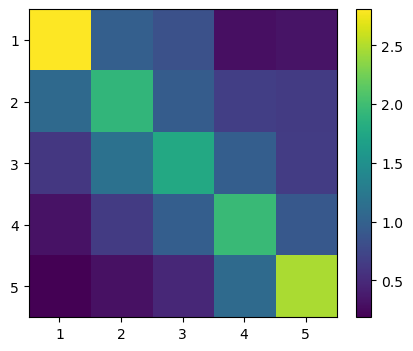

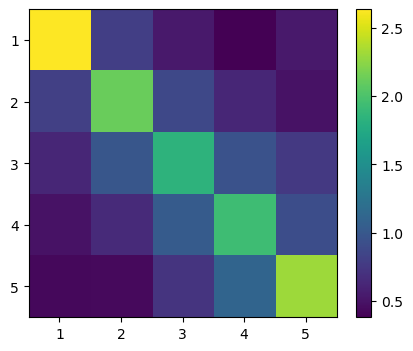

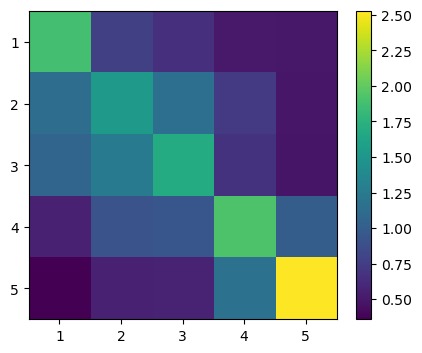

In [10]:
import matplotlib.pyplot as plt

behavior_type = "masks"
matrix = results['matrices'][behavior_type]

plt.figure(figsize=(5, 4))
im = plt.imshow(matrix, cmap='viridis')
plt.xticks(range(5), range(1, 6))
plt.yticks(range(5), range(1, 6))
plt.colorbar(im)
plt.savefig('figures/Fig_2/masks_contact_matrix.png', dpi=300, bbox_inches='tight')

behavior_type = "testing"
matrix = results['matrices'][behavior_type]

plt.figure(figsize=(5, 4))
im = plt.imshow(matrix, cmap='viridis')
plt.xticks(range(5), range(1, 6))
plt.yticks(range(5), range(1, 6))
plt.colorbar(im)
plt.savefig('figures/Fig_2/testing_contact_matrix.png', dpi=300, bbox_inches='tight')

behavior_type = "vacc"
matrix = results['matrices'][behavior_type]

plt.figure(figsize=(5, 4))
im = plt.imshow(matrix, cmap='viridis')
plt.xticks(range(5), range(1, 6))
plt.yticks(range(5), range(1, 6))
plt.colorbar(im)
plt.savefig('figures/Fig_2/vacc_contact_matrix.png', dpi=300, bbox_inches='tight')